In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf


2024-12-04 16:25:01.722897: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 16:25:01.732090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733329501.741172   24734 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733329501.743895   24734 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 16:25:01.754866: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
def calculate_ema(series, length):
    """
    Calculate Exponential Moving Average (EMA) for a Pandas Series.
    
    Args:
    - series (pd.Series): The data for which EMA is to be calculated (e.g., 'close' prices).
    - length (int): The period length for EMA (e.g., 10 for EMA_10).
    
    Returns:
    - pd.Series: EMA values.
    """
    alpha = 2 / (length + 1)
    ema = series.ewm(alpha=alpha, adjust=False).mean()
    return ema

# Example usage
#df['EMA_10'] = calculate_ema(df['close'], length=10)

def calculate_rsi(series, length=14):
    """
    Calculate Relative Strength Index (RSI) for a Pandas Series.
    
    Args:
    - series (pd.Series): The data for which RSI is to be calculated (e.g., 'close' prices).
    - length (int): The period length for RSI (default is 14).
    
    Returns:
    - pd.Series: RSI values.
    """
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)  # Positive changes
    loss = -delta.where(delta < 0, 0)  # Negative changes (converted to positive)
    
    avg_gain = gain.rolling(window=length, min_periods=length).mean()
    avg_loss = loss.rolling(window=length, min_periods=length).mean()
    
    # Use exponentially weighted moving average for smoothing (optional, common in practice)
    avg_gain = avg_gain.ewm(com=length - 1, adjust=False).mean()
    avg_loss = avg_loss.ewm(com=length - 1, adjust=False).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

# Example usage
#df['RSI'] = calculate_rsi(df['close'], length=14)


def calculate_macd(series, fast_length=12, slow_length=26, signal_length=9):
    """
    Calculate MACD (Moving Average Convergence Divergence) for a Pandas Series.
    
    Args:
    - series (pd.Series): The data for which MACD is to be calculated (e.g., 'close' prices).
    - fast_length (int): The period for the fast EMA (default is 12).
    - slow_length (int): The period for the slow EMA (default is 26).
    - signal_length (int): The period for the signal line EMA (default is 9).
    
    Returns:
    - pd.DataFrame: DataFrame containing MACD line, signal line, and histogram.
    """
    fast_ema = series.ewm(span=fast_length, adjust=False).mean()
    slow_ema = series.ewm(span=slow_length, adjust=False).mean()
    macd_line = fast_ema - slow_ema
    signal_line = macd_line.ewm(span=signal_length, adjust=False).mean()
    histogram = macd_line - signal_line
    
    return pd.DataFrame({
        'MACD': macd_line,
        'Signal': signal_line,
        'Histogram': histogram
    })

# Example usage
#macd = calculate_macd(df['close'])
#df['MACD'] = macd['MACD']
#df['Signal'] = macd['Signal']
#df['Histogram'] = macd['Histogram']



In [28]:
df = pd.read_pickle("Screened_NWG.pkl")



In [29]:
def create_sequences_multifeature(data, target_feature, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])  # Collect the window of all features
        y.append(data[i + window_size, target_feature])  # Predict only the target feature (e.g., "high")
    return np.array(X), np.array(y)


# Add indicators to the DataFrame
df['SMA_10'] = df['high'].rolling(window=10).mean()
df['EMA_10'] = calculate_ema(df['high'], length=10)  # Exponential Moving Average (10 periods)
df['RSI'] = calculate_rsi(df['high'], length=14)     # Relative Strength Index (14 periods)
macd = calculate_macd(df['high'])
df['MACD'] = macd['MACD']
df['Signal'] = macd['Signal']
df['Histogram'] = macd['Histogram']

# Prepare the dataset
#features = df[["open", "high", "low", "close"]].values  # Shape (num_samples, 4)

df2=df.dropna()

features = df2[[ 'high',  'SMA_10', 'EMA_10', 'RSI', 'MACD', 'Signal', 'Histogram']].values
#features = df2[['open', 'high', 'low', 'close', 'SMA_10', 'EMA_10', 'RSI', 'MACD', 'Signal', 'Histogram']].values
#print(features.isna().sum())

target_feature_index = 0  # Index of "high" in the features array

# Normalize the data (optional but recommended)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#scaler = MinMaxScaler()
#features_normalized = scaler.fit_transform(features)

# Scaler for input features (open, high, low, close)
feature_scaler = MinMaxScaler()
features_normalized = feature_scaler.fit_transform(features)

# Scaler for target feature (high)
target_scaler = MinMaxScaler()
high_normalized = target_scaler.fit_transform(features[:, 1].reshape(-1, 1))  # Only scale "high"


# Create sequences
window_size = 15
X, y = create_sequences_multifeature(features_normalized, target_feature_index, window_size)

# Adjust X shape for the GRU model (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))  # Shape (num_samples, window_size, num_features)


In [30]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [31]:
from keras.layers import GRU, Dropout, Dense
from keras.models import Sequential

gru_model = Sequential()

# First GRU layer with dropout
gru_model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(Dropout(0.2))

# Second GRU layer with dropout
gru_model.add(GRU(50, return_sequences=True))
gru_model.add(Dropout(0.2))

# Third GRU layer with dropout
gru_model.add(GRU(50, return_sequences=True))
gru_model.add(Dropout(0.2))

# Fourth GRU layer with dropout
gru_model.add(GRU(50))
gru_model.add(Dropout(0.2))

# Output layer
gru_model.add(Dense(1))

gru_model.compile(optimizer='adam', loss='mean_squared_error',  metrics=['accuracy'])

gru_model.summary()


/home/dave/tf/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_12 (GRU)                    │ (None, 15, 50)         │         8,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 15, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ (None, 15, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 15, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_14 (GRU)                    │ (None, 15, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 15, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_15 (GRU)                    │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,801 (214.07 KB)

 Trainable params: 54,801 (214.07 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
#gru_model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=30, batch_size=24, verbose=1)

history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 9.8363e-04 - loss: 0.0367 - val_accuracy: 0.0044 - val_loss: 0.0051
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 2.9567e-04 - loss: 0.0052 - val_accuracy: 0.0044 - val_loss: 0.0029
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.8093e-04 - loss: 0.0036 - val_accuracy: 0.0044 - val_loss: 0.0042
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 3.9716e-04 - loss: 0.0033 - val_accuracy: 0.0044 - val_loss: 0.0011
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0019 - loss: 0.0041 - val_accuracy: 0.0044 - val_loss: 0.0024
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0014 - loss: 0.0031 - val_accuracy: 0.0044 - val_loss: 0.0012
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 2.7172e-04 - loss: 0.0036 - val_accuracy: 0.0044 - val_loss: 0.0017
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 4.8008e-04 - loss: 0.0029 - 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


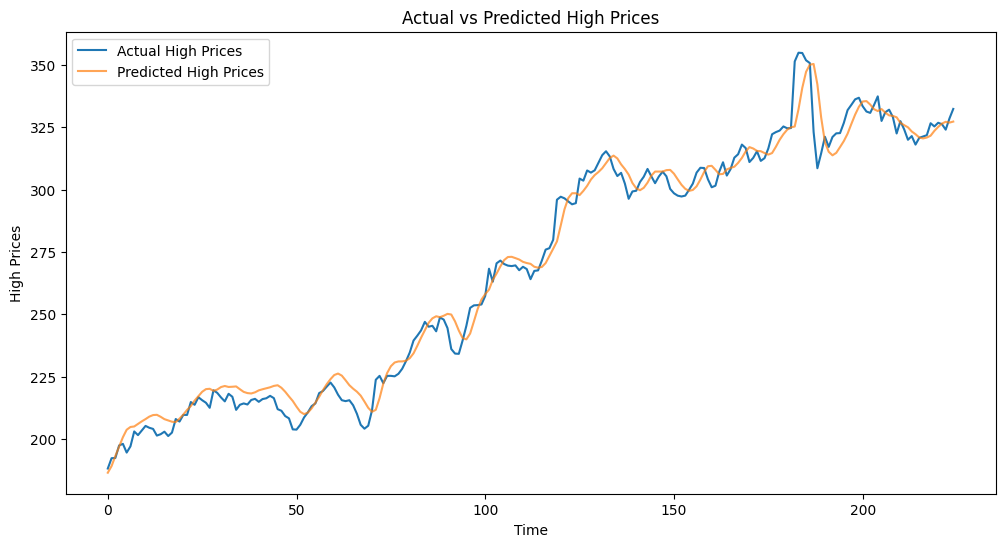

In [33]:
import matplotlib.pyplot as plt

# Predict
predicted_gru = gru_model.predict(X_test)

# Inverse transform the predicted and actual values
predicted_gru_actual = target_scaler.inverse_transform(predicted_gru)  # Use target scaler for "high"
y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))  # Reshape y_test to (num_samples, 1)

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual High Prices")
plt.plot(predicted_gru_actual, label="Predicted High Prices", alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted High Prices")
plt.xlabel("Time")
plt.ylabel("High Prices")
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0021 - loss: 5.1603e-04     
Test Accuracy: 0.00


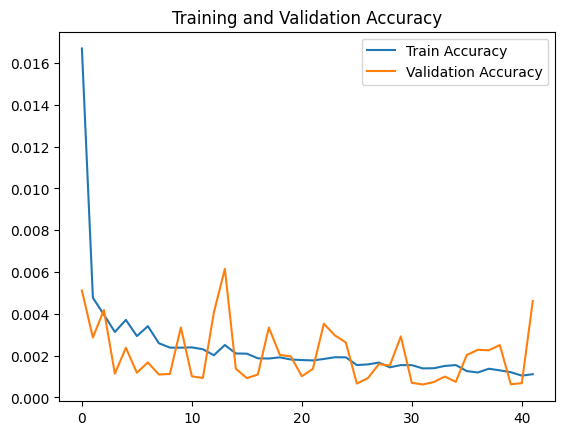

In [36]:
# Evaluate the model
loss, accuracy = gru_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Visualize results
#import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [27]:
from keras.layers import LSTM, Dropout, SimpleRNN

lstm_model = Sequential()

# First LSTM layer with dropout
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))

# Second LSTM layer with dropout
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(Dropout(0.2))

# Third LSTM layer with dropout
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(Dropout(0.2))

# Fourth LSTM layer with dropout
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))

# Output layer
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.summary()

/home/dave/tf/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 15, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 15, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 15, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 15, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 15, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
lstm_model.fit(X_train, y_train, epochs=30, batch_size=24, verbose=1)

NameError: name 'lstm_model' is not defined

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


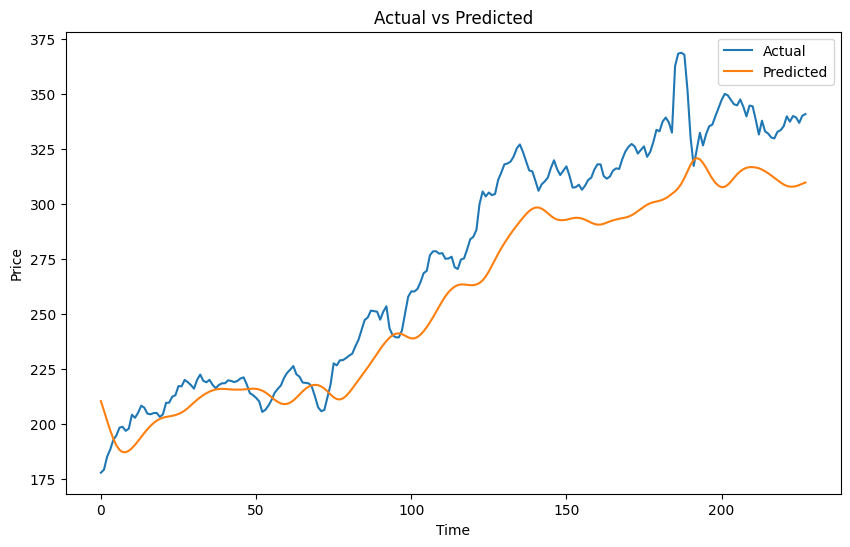

In [29]:
import matplotlib.pyplot as plt

# Make predictions
predicted_lstm = lstm_model.predict(X_test)

# Inverse transform the predicted and actual values
predicted_lstm = scaler.inverse_transform(predicted_lstm)
y_test_actual = scaler.inverse_transform(y_test)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(predicted_lstm, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()